# Сравнение Retention рекламной кампании и естественного трафика

***14 мая 2023*** года была запущенна рекламная кампания по привлечению трафика, необходимо определить эффективность кампании.

Для определения эффективности и качества трафика будем сравнивать два источника: 
1. Пользователи, которые пришли 14 мая от рекламной кампании
2. Пользователи, которые за 3 дня ДО рекламы и 3 дня ПОСЛЕ рекламы

-----

Подключаем библиотеку `pandahouse` для отработки запросов к БД clickhouse 

In [ ]:
import pandahouse

connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20230520'
}

q = "SELECT user_id, toDate(time) as time, source FROM {db}.feed_actions"

df = pandahouse.read_clickhouse(q, connection=connection)

In [2]:
df

,user_id,time,source
0,63830,2023-06-07,ads
1,126860,2023-06-07,organic
2,128603,2023-06-07,organic
3,130058,2023-06-07,organic
4,147928,2023-06-07,organic
...,...,...,...
55283703,108633,2023-06-28,organic
55283704,115307,2023-06-28,organic
55283705,117768,2023-06-28,organic
55283706,123018,2023-06-28,organic


Для каждого пользователя определим минимальную дату взаимодействия

In [3]:
first_action_user = df.groupby('user_id')['time'].min()

Теперь выполним `join` двух таблиц, чтобы увидеть дату первого взаимодействия каждого пользователя

In [ ]:
merged_df = df.merge(first_action_user, how='left', on='user_id')

Выполним фильтрацую по дате первого взаимодействия, нас интересует пользователи которые пришли 14 мая 2023 г.

In [30]:
df_sorted = merged_df[merged_df['time_y']=='2023-05-14']

Для удобства переименую названия столбцев, которые получились после `join`.

1. заменим `time_x` на `action_time` - т.е. дата взаимодействия
2. заменим `time_y` на `first_action` - т.е. дата первого взаимодействия

In [33]:
df_sorted.rename(columns={'time_x':'action_time', 'time_y':'first_action'}, inplace=True)

Убираем дубликаты из таблицы, т.к. если пользователь совершил хотя бы 1 действие в дату, то этого достаточно

In [36]:
df_sorted.drop_duplicates(inplace=True)

Рассчитываем `Retention` для каждой группы

In [56]:
retention = df_sorted.groupby(['source', 'first_action','action_time'])['user_id'].count().reset_index()

In [62]:
retention.rename(columns={'user_id':'retention'}, inplace=True)

In [69]:
retention

,source,first_action,action_time,retention
0,ads,2023-05-14,2023-05-14,3688
1,ads,2023-05-14,2023-05-15,106
2,ads,2023-05-14,2023-05-16,124
3,ads,2023-05-14,2023-05-17,122
4,ads,2023-05-14,2023-05-18,108
5,ads,2023-05-14,2023-05-19,123
6,ads,2023-05-14,2023-05-20,93
7,ads,2023-05-14,2023-05-21,84
8,ads,2023-05-14,2023-05-22,88
9,ads,2023-05-14,2023-05-23,57


Рассчитаем процентное изменение `retention`

In [78]:
max_rt_ads = retention[retention['source']=='ads']['retention'].max()
max_rt_organic = retention[retention['source']=='organic']['retention'].max()

In [82]:
def retention_rate_share(row):
    if row['source'] == 'ads':
        return round(row['retention']*100/max_rt_ads,2)
    else:
        return round(row['retention']*100/max_rt_organic,2)


retention['retention_share'] = retention.apply(retention_rate_share, axis=1)

In [83]:
retention

,source,first_action,action_time,retention,retention_share
0,ads,2023-05-14,2023-05-14,3688,100.00
1,ads,2023-05-14,2023-05-15,106,2.87
2,ads,2023-05-14,2023-05-16,124,3.36
3,ads,2023-05-14,2023-05-17,122,3.31
4,ads,2023-05-14,2023-05-18,108,2.93
5,ads,2023-05-14,2023-05-19,123,3.34
6,ads,2023-05-14,2023-05-20,93,2.52
7,ads,2023-05-14,2023-05-21,84,2.28
8,ads,2023-05-14,2023-05-22,88,2.39
9,ads,2023-05-14,2023-05-23,57,1.55


Сравним полученные результаты:

Как мы видим, действительно рекламная кампания удалась и привлекла большое количетсво пользователей, но качество такого трафика по сравнения с естесвенным очень низкое.

Заметно, что `retention` 1 дня для рекламной кампании составляет ***2.87%***, что является очень низким по сравнению с естественным трафиком.

---

Выполним визуализацию данных для нагладности

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

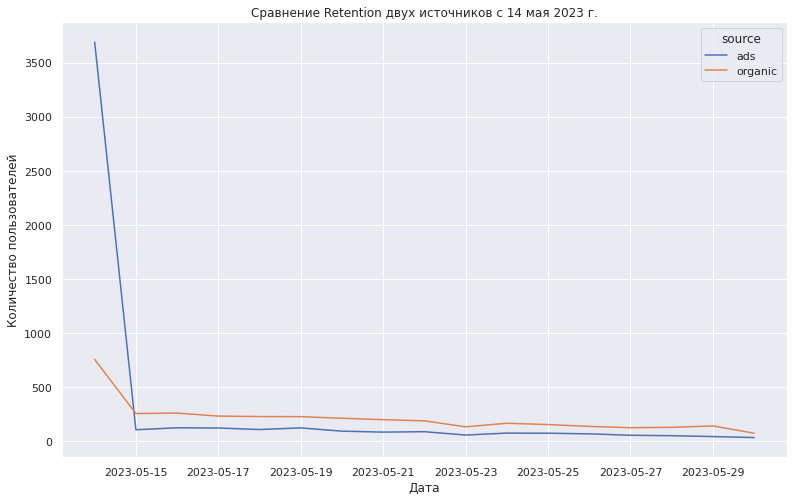

In [60]:
fig, ax = plt.subplots(figsize=(13, 8))
sns.set_theme()
sns.lineplot(data = retention, x='action_time', y='user_id', hue='source', ax=ax)
plt.title('Сравнение Retention двух источников с 14 мая 2023 г.')
plt.ylabel('Количество пользователей')
plt.xlabel('Дата')
plt.show()

***Вывод:*** рекламная кампания привлекла дейсвительно много новых пользоватлей на момент запуска, но почти 98% трафика перестало пользоваться нашим приложение уже на следующий день.